In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import json
import matplotlib
from helper.cdf import cdf


plt.rcParams.update({'font.size': 16})

In [2]:
df = pandas.read_csv('./data_out/nb_processed_cell_html.csv', converters={'_table_metadata': json.loads})
df.head()

,fileNames,cell_seq_num,cellType,_has_output,_no_outputs,_output_contains_graphics,_output_contains_tables,_has_interactive,_has_heading,_has_links,...,h1_texts,h2_texts,h3_texts,h4_texts,h5_texts,h6_texts,has_tables,has_math,num_math,alt_text
0,serve/light/107d73eda168b7699d80351e4995937d6a...,0,markdown,False,False,False,False,False,False,False,...,[],[],[],[],[],[],False,False,0,[]
1,serve/light/107d73eda168b7699d80351e4995937d6a...,1,markdown,False,False,False,False,False,False,False,...,[],[],[],[],[],[],False,False,0,"[""Impressions""]"
2,serve/light/107d73eda168b7699d80351e4995937d6a...,2,markdown,False,False,False,False,False,True,True,...,"[""Reinforcement Learning in Azure Machine Lear...",[],[],[],[],[],False,False,0,[]
3,serve/light/107d73eda168b7699d80351e4995937d6a...,3,markdown,False,False,False,False,False,True,True,...,[],[],"[""Cartpole problem""]",[],[],[],True,False,0,"[""Cartpole image""]"
4,serve/light/107d73eda168b7699d80351e4995937d6a...,4,markdown,False,False,False,False,False,True,True,...,[],[],"[""Prerequisite""]",[],[],[],False,False,0,[]


In [3]:
def process_r_c_tuples(item):
    s = []
    for d in item:
        s.append((d['num_rows'], d['num_columns']))
    return s

def flatten(arr):
    r = []
    for i in arr:
        for x in i:
            r.append(x)
    return r

In [4]:
df = df[['fileNames', '_num_tables', '_table_metadata', 'has_tables']]

In [5]:
df['table_metadata'] = df['_table_metadata'].apply(lambda x: process_r_c_tuples(x))

gdf = df.groupby(['fileNames']).agg({'table_metadata': lambda x: list(x)})
gdf['table_metadata'] = gdf['table_metadata'].apply(lambda r: flatten(r))
gdf['num_tables'] = gdf['table_metadata'].apply(lambda x: len(x))

## Figure 2(a): Distribution of number of plots in each notebook

In [6]:
df = pandas.read_csv('./data_out/processed_function_calls.csv')

In [7]:
df['import_count'] = df['imports'].apply(lambda r: len(set(json.loads(r))))

In [8]:
import_list = [json.loads(f) for f in df['imports'].tolist()]


In [9]:
used_imports = {}

for import_list_segment in import_list:
    for import_item in import_list_segment:
        if import_item not in used_imports:
            used_imports[import_item] = 0
        used_imports[import_item] = used_imports[import_item] + 1

In [10]:
row = []
for k, v in used_imports.items():
    row.append([k.strip(), v])

import_df = pandas.DataFrame(data=row, columns=['Function', 'Count'])
import_df = import_df.sort_values(by=['Count'], ascending=False)

In [11]:
plot_df = import_df[(import_df['Function'].str.contains('mat')) | (import_df['Function'].str.contains('sea'))]

In [12]:
image_notebooks_data = df['numImages'].value_counts().to_dict()

In [13]:
n_count = []
keys = sorted(list(image_notebooks_data.keys()))
for k in keys:
    occurences = image_notebooks_data[k]
    value_occurred = k
    for i in range(0, occurences):
        n_count.append(value_occurred)

print(len(n_count))

39540


In [14]:
df.shape

(39540, 7)

In [15]:
# TODO: remove the static number
TOTAL_NOTEBOOKS_CONSIDERED = 92050

# Fill zeros
zero_list = [0 for i in range(0, TOTAL_NOTEBOOKS_CONSIDERED-len(n_count))]

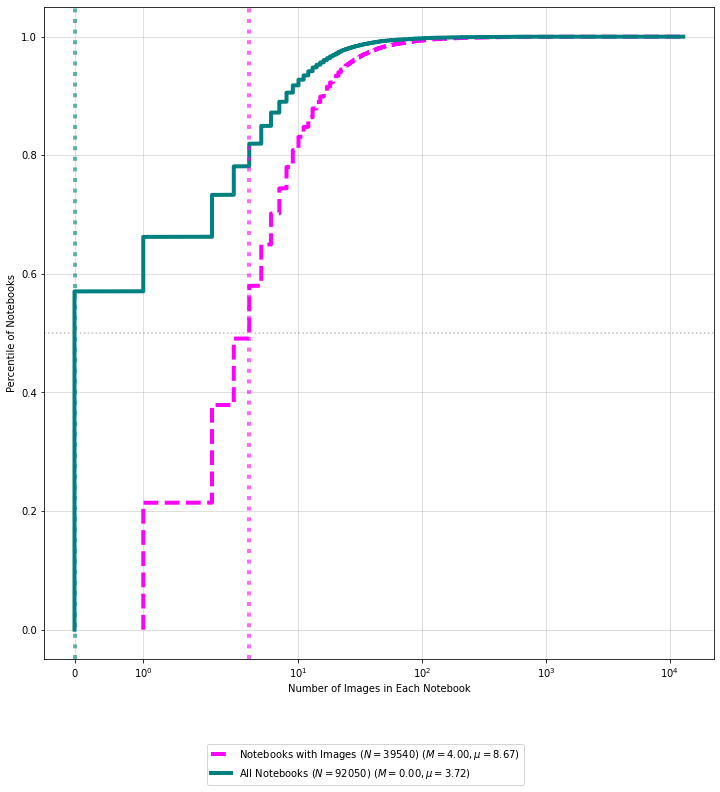

In [16]:
import numpy
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
only_image_notebooks_X, only_image_notebooks_Y = cdf(n_count)
all_image_data_notebooks = zero_list + n_count
all_image_notebooks_X, all_image_notebooks_Y = cdf(all_image_data_notebooks)

median_images_in_all_notebooks = numpy.percentile(all_image_notebooks_X, 50.0)
median_images_in_notebooks_with_images = numpy.percentile(only_image_notebooks_X, 50.0)

mean_images_in_all_notebooks = numpy.mean(all_image_notebooks_X)
mean_images_in_notebooks_with_images = numpy.mean(only_image_notebooks_X)

ax.plot(
    only_image_notebooks_X,
    only_image_notebooks_Y,
    linewidth=4,
    linestyle='--',
    label=f"Notebooks with Images ($N={len(only_image_notebooks_X)}$) $(M={median_images_in_notebooks_with_images:.2f}, \mu={mean_images_in_notebooks_with_images:.2f})$",
    color='magenta')
ax.plot(
    all_image_notebooks_X,
    all_image_notebooks_Y,
    linewidth=4,
    label=f'All Notebooks ($N={len(all_image_notebooks_X)}$) $(M={median_images_in_all_notebooks:.2f}, \mu={mean_images_in_all_notebooks:.2f})$',
    color='teal')
ax.legend(
    fancybox=True,
    bbox_to_anchor=(0.48, -0.2),
    loc='lower center'
)
ax.grid(True, alpha=0.5)
ax.set_xscale('symlog')

ax.axvline(
    median_images_in_notebooks_with_images,
    linestyle=':',
    linewidth=4,
    alpha=0.6,
    color='magenta')
ax.axvline(
    median_images_in_all_notebooks,
    linestyle=':',
    linewidth=4,
    alpha=0.6,
    color='teal')

ax.axhline(0.5, linestyle=':', color="gray", alpha=0.5)

ax.set_xlabel('Number of Images in Each Notebook')
ax.set_ylabel('Percentile of Notebooks')

plt.savefig(f'plot_out/fig-2a-cdf_images_in_notebook.pdf', bbox_inches='tight')

**Figure 2(a)** shows the distribution of the number of plots in each notebook indicating the median number of plots in 39540 notebooks containing images as 4.0, and all 92050 python notebooks as 0 with a mean at 3.72.

## Figure 2(b): Distribution of number of tables in notebooks

count    98222.00000
mean         1.90158
std          8.06090
min          0.00000
25%          0.00000
50%          0.00000
75%          2.00000
max       1181.00000
Name: num_tables, dtype: float64
count    33632.000000
mean         5.553550
std         13.018825
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max       1181.000000
Name: num_tables, dtype: float64


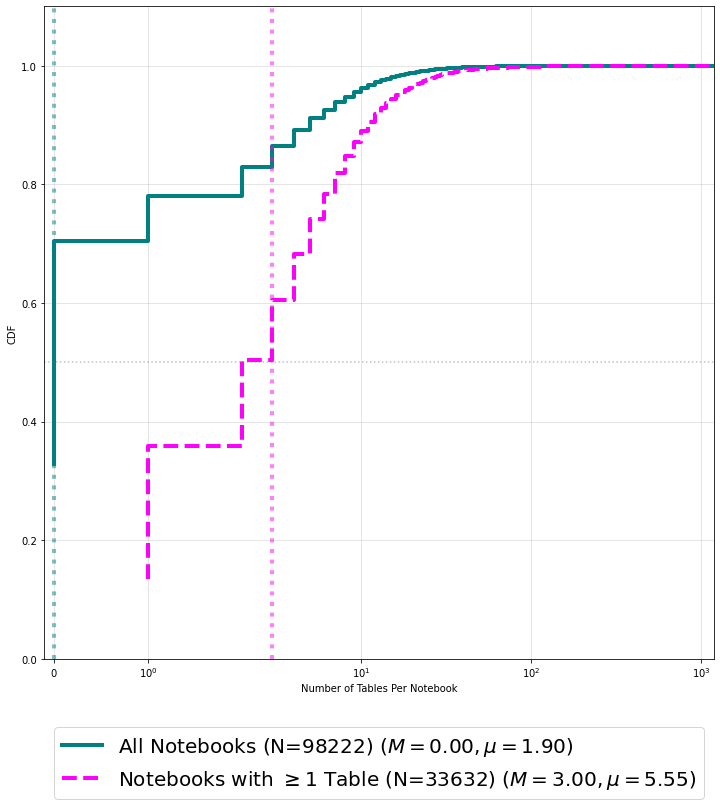

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

matplotlib.rcParams.update({'font.size': 20})

num_tables_x, num_tables_y = cdf(gdf['num_tables'].tolist())
median_tables_all = numpy.median(num_tables_x)
mean_tables_all = numpy.mean(num_tables_x)

sns.lineplot(x=num_tables_x, y=num_tables_y,
             ax=ax, drawstyle='steps-pre',
             linewidth=4,
             ci=None,
             linestyle='-',
             color='teal',
             label=f'All Notebooks (N={gdf.shape[0]}) $(M={median_tables_all:.2f},\mu={mean_tables_all:.2f})$')

gdf_nozero = gdf[gdf['num_tables'] > 0]
num_tables_nozero_x, num_tables_nozero_y = cdf(gdf_nozero['num_tables'].tolist())
median_tables_nozero = numpy.median(num_tables_nozero_x)
mean_tables_nozero = numpy.mean(num_tables_nozero_x)

print(gdf['num_tables'].describe())
print(gdf_nozero['num_tables'].describe())

sns.lineplot(x=num_tables_nozero_x, y=num_tables_nozero_y,
             drawstyle='steps-pre',
             ax=ax,
             linewidth=4,
             ci=None,
             color='magenta',
             linestyle='--',
             label=f'Notebooks with $\geq$1 Table (N={gdf_nozero.shape[0]}) $(M={median_tables_nozero:.2f},\mu={mean_tables_nozero:.2f})$')

horizontal_line = ax.axhline(y=0.5, linestyle=':', color='gray', alpha=0.5)

ax.axvline(x=median_tables_all, linestyle=':', color='teal', alpha=0.5, linewidth=4)
ax.axvline(x=median_tables_nozero, linestyle=':', color='magenta', alpha=0.5, linewidth=4)

ax.grid(True, alpha=0.4)
ax.set_xscale('symlog')
ax.set_xlim(-0.1, max(num_tables_x[-1], num_tables_nozero_x[-1]))
ax.set_ylim(0, 1.1)

ax.set_xlabel('Number of Tables Per Notebook')
ax.set_ylabel('CDF')

ax.legend(fancybox=True, bbox_to_anchor=(0.45, -0.23, 0.1, 0.1), loc='lower center')

plt.savefig('plot_out/fig-2b-cdf-tables-in-notebooks.pdf', bbox_inches='tight')

**Figure 2(b)** shows the distribution of the number of tables in notebooks. The solid teal line indicates that a notebook at the median contains no tables, with the average notebook containing 1.9 tables. However, the magenta line displaced to the right of the teal line in the figure indicates a median of 3 and a mean of 5.55 number of tables in the dataset. 

## Figure 2(c) Distribution of number of rows and columns in tables

Rows: [p25] = 5.0
Cols: [p25] = 12.0

Rows: [p50] = 6.0
Cols: [p50] = 30.0

Rows: [p75] = 10.0
Cols: [p75] = 77.0

Rows: [p80] = 11.0
Cols: [p80] = 104.0

Rows: [p85] = 12.0
Cols: [p85] = 110.0

Rows: [p88] = 16.0
Cols: [p88] = 136.0

Rows: [p90] = 21.0
Cols: [p90] = 174.0

Rows: [p95] = 62.0
Cols: [p95] = 366.0

Rows: [p99] = 63.0
Cols: [p99] = 1281.0

Rows: [p100] = 162736.0
Cols: [p100] = 1139145.0



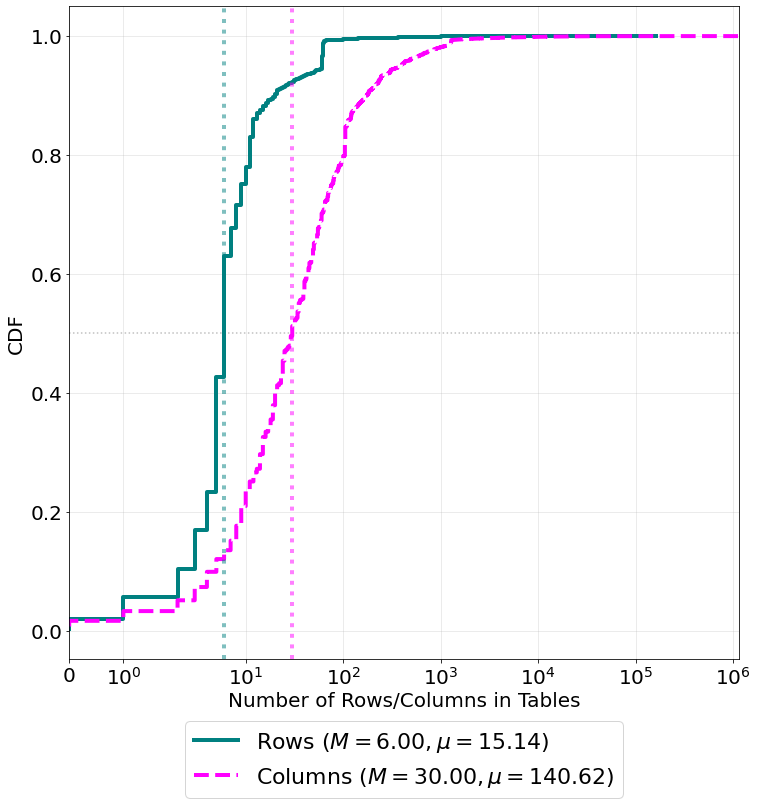

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

matplotlib.rcParams.update({'font.size': 22})

rows = []
cols = []
row_col_details = []
elements = gdf['table_metadata'].tolist()
for d in elements:
    for pair in d:
        row_col_details.append(pair)
        rows.append(pair[0])
        cols.append(pair[1])

rows_x, rows_y = cdf(rows)
cols_x, cols_y = cdf(cols)
for p in [25, 50, 75, 80, 85, 88, 90, 95, 99, 100]:
    print(f'Rows: [p{p}] = {numpy.percentile(rows_x, p)}')
    print(f'Cols: [p{p}] = {numpy.percentile(cols_x, p)}')
    print()
    
    
horizontal_line = ax.axhline(y=0.5, linestyle=':', color='gray', alpha=0.5)
median_rows = numpy.median(rows_x)
median_cols = numpy.median(cols_x)
mean_rows = numpy.mean(rows_x)
mean_cols = numpy.mean(cols_x)

sns.lineplot(x=rows_x, y=rows_y,
             drawstyle='steps-pre',
             ci=None, ax=ax,
             color='teal',
             linewidth=4,
             label=f'Rows $(M={median_rows:.2f},\mu={mean_rows:.2f})$')

sns.lineplot(x=cols_x, y=cols_y,
             drawstyle='steps-pre',
             ci=None, ax=ax,
             color='magenta',
             linewidth=4,
             linestyle='--',
             label=f'Columns $(M={median_cols:.2f},\mu={mean_cols:.2f})$')


ax.axvline(x=median_rows, linestyle=':', color='teal', alpha=0.5, linewidth=4)
ax.axvline(x=median_cols, linestyle=':', color='magenta', alpha=0.5, linewidth=4)

ax.set_xscale('symlog')
ax.set_xlim(0, max(rows_x[-1], cols_x[-1]))

ax.set_xlabel('Number of Rows/Columns in Tables')
ax.set_ylabel('CDF')

ax.grid(True, alpha=0.3)

ax.legend(fancybox=True, bbox_to_anchor=(0.45, -0.23, 0.1, 0.1), loc='lower center')
plt.savefig('./plot_out/fig-2c-table-row-columns-cdf.pdf', bbox_inches='tight')

**Figure 2(c)** presents the distribution of the number of rows in tables using the solid teal line and the distribution of number of columns in the tables using the dashed magenta line. The median number of rows for a table is 6, with the average at 15.14, and the median number of columns for the tables are 30, with the average at 140.62. All three figures use the same consistent color scheme and contain legends below the x axis.
